# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

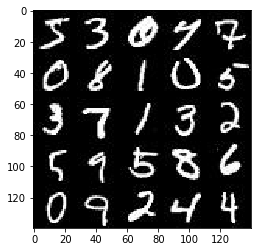

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

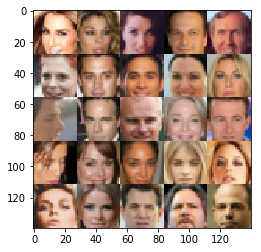

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_height, image_width, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [56]:
def discriminator(images, reuse=False, alpha=0.2, drop_prop=0.5, size_mult=128):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # the shape of images is (28, 28, 3)
        # try use tf.contrib.layers.xavier_initializer as kernel_initializer for better perfermence
        x = tf.layers.conv2d(images, size_mult, 5, strides=2, padding='same'
                             , kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.maximum(alpha * x, x)
        # now the shape is (14, 14, 128)
        
        x = tf.layers.conv2d(x, 2 * size_mult, 5, strides=1, padding='same'
                             , kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        # now the shape is (14, 14, 256)
        
        x = tf.layers.conv2d(x, 4 * size_mult, 5, strides=2, padding='same'
                             , kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        # now the shape is (7, 7, 512)
        
        x = tf.reshape(x, (-1, 7 * 7 * 4 * size_mult))
        logits = tf.layers.dense(x, 1)
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [51]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, size_mult=128):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 7 * 7 * 4 * size_mult)
        x = tf.reshape(x, (-1, 7, 7, 4 * size_mult))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x * alpha, x)
        # now the shape of x is (7, 7, 512)
        
        x = tf.layers.conv2d_transpose(x, 2*size_mult, 5, strides=1, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x * alpha, x)
        # now the shape of x is (7, 7, 256)
        
        x = tf.layers.conv2d_transpose(x, size_mult, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x * alpha, x)
        # now the shape of x is (14, 14, 128)

        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same')
        # now the shape of x is (28, 28, out_channel_dim)
        output = tf.tanh(logits)

        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [43]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, \
                                                                         labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, \
                                                                         labels=tf.zeros_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, \
                                                                    labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [44]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to updat
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [45]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [65]:
from scipy.stats import truncnorm

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    out_channel_dim = 3
    if data_image_mode == 'L':
        out_channel_dim = 1
    
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim, smooth=0.1, alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 40
    show_every = 200

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # gotcha!! the value range of batch_images is [-0.5, 0.5], should x 2
                batch_images *= 2.0
                steps += 1
                
                # sample random noise for G
#                 batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # try using gaussian distribution instead of uniform
                batch_z = truncnorm(-1, 1).rvs(size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate})
                # Dont balance loss via statistics (unless you have a good reason to)
                # try run generator optimizer one more time each batch
#                 _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    # get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs), \
                        "Discriminator Loss: {:.4f}...".format(train_loss_d),
                        "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    # show generator output
                    show_generator_output(sess, show_n_images, input_z, out_channel_dim, data_image_mode)
                    
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 2.6138... Generator Loss: 0.8827
Epoch 1/2... Discriminator Loss: 2.5231... Generator Loss: 0.1698
Epoch 1/2... Discriminator Loss: 2.3307... Generator Loss: 0.8015
Epoch 1/2... Discriminator Loss: 1.4994... Generator Loss: 0.7646
Epoch 1/2... Discriminator Loss: 1.5427... Generator Loss: 0.4661


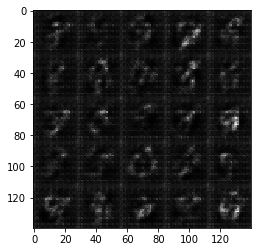

Epoch 1/2... Discriminator Loss: 1.3168... Generator Loss: 0.7248
Epoch 1/2... Discriminator Loss: 1.2517... Generator Loss: 1.5641
Epoch 1/2... Discriminator Loss: 1.5386... Generator Loss: 0.5010
Epoch 1/2... Discriminator Loss: 1.2849... Generator Loss: 1.0624
Epoch 1/2... Discriminator Loss: 1.2405... Generator Loss: 1.2553


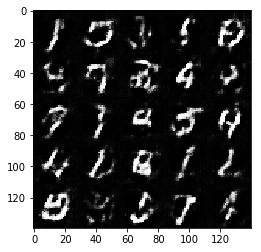

Epoch 1/2... Discriminator Loss: 1.1723... Generator Loss: 0.9722
Epoch 1/2... Discriminator Loss: 1.7012... Generator Loss: 0.5150
Epoch 1/2... Discriminator Loss: 1.2764... Generator Loss: 0.8074
Epoch 1/2... Discriminator Loss: 1.4871... Generator Loss: 0.6176
Epoch 1/2... Discriminator Loss: 1.6443... Generator Loss: 0.4143


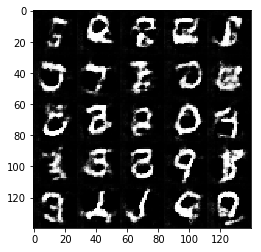

Epoch 1/2... Discriminator Loss: 1.7798... Generator Loss: 0.3060
Epoch 1/2... Discriminator Loss: 1.4996... Generator Loss: 0.4879
Epoch 1/2... Discriminator Loss: 1.7585... Generator Loss: 0.3718
Epoch 1/2... Discriminator Loss: 1.2818... Generator Loss: 1.0079
Epoch 1/2... Discriminator Loss: 1.5734... Generator Loss: 0.4526


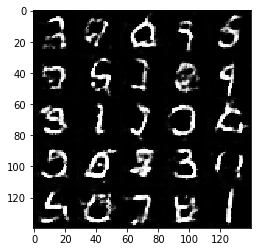

Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 0.5885
Epoch 1/2... Discriminator Loss: 1.6002... Generator Loss: 0.3994
Epoch 1/2... Discriminator Loss: 1.9346... Generator Loss: 0.2931
Epoch 1/2... Discriminator Loss: 1.4547... Generator Loss: 0.5843
Epoch 1/2... Discriminator Loss: 1.2935... Generator Loss: 0.5966


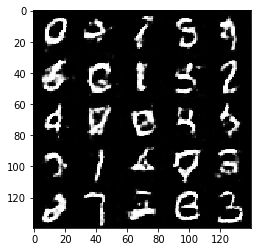

Epoch 1/2... Discriminator Loss: 1.8292... Generator Loss: 0.3402
Epoch 1/2... Discriminator Loss: 1.4307... Generator Loss: 0.6193
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.6179
Epoch 1/2... Discriminator Loss: 1.4643... Generator Loss: 0.5629
Epoch 1/2... Discriminator Loss: 1.1493... Generator Loss: 1.0199


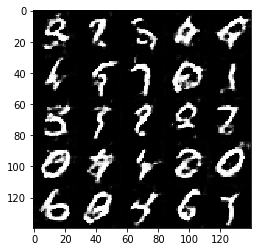

Epoch 1/2... Discriminator Loss: 1.5586... Generator Loss: 0.4555
Epoch 1/2... Discriminator Loss: 1.3621... Generator Loss: 1.1226
Epoch 1/2... Discriminator Loss: 1.4847... Generator Loss: 0.5891
Epoch 1/2... Discriminator Loss: 1.7452... Generator Loss: 0.3200
Epoch 1/2... Discriminator Loss: 2.4058... Generator Loss: 0.1708


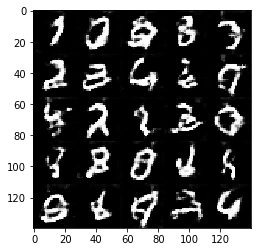

Epoch 1/2... Discriminator Loss: 1.3798... Generator Loss: 1.4379
Epoch 1/2... Discriminator Loss: 1.2057... Generator Loss: 0.7603
Epoch 1/2... Discriminator Loss: 1.2116... Generator Loss: 0.8097
Epoch 1/2... Discriminator Loss: 1.6832... Generator Loss: 0.3784
Epoch 1/2... Discriminator Loss: 1.5166... Generator Loss: 0.4696


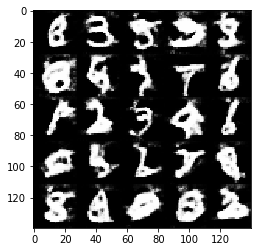

Epoch 1/2... Discriminator Loss: 1.2453... Generator Loss: 0.7797
Epoch 1/2... Discriminator Loss: 1.1247... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 2.4452... Generator Loss: 0.2059
Epoch 1/2... Discriminator Loss: 1.4748... Generator Loss: 0.4589
Epoch 1/2... Discriminator Loss: 1.2189... Generator Loss: 0.9719


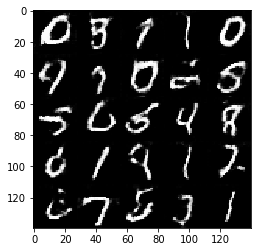

Epoch 1/2... Discriminator Loss: 1.4017... Generator Loss: 0.6118
Epoch 2/2... Discriminator Loss: 1.8220... Generator Loss: 0.3074
Epoch 2/2... Discriminator Loss: 1.5087... Generator Loss: 2.0983
Epoch 2/2... Discriminator Loss: 1.2464... Generator Loss: 0.6996
Epoch 2/2... Discriminator Loss: 1.2100... Generator Loss: 1.7016


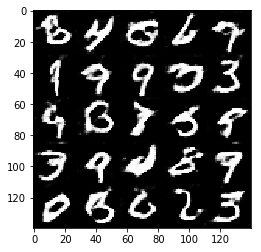

Epoch 2/2... Discriminator Loss: 1.0669... Generator Loss: 0.9974
Epoch 2/2... Discriminator Loss: 1.4698... Generator Loss: 0.4988
Epoch 2/2... Discriminator Loss: 1.3110... Generator Loss: 0.8776
Epoch 2/2... Discriminator Loss: 1.4638... Generator Loss: 0.5926
Epoch 2/2... Discriminator Loss: 1.4643... Generator Loss: 2.2454


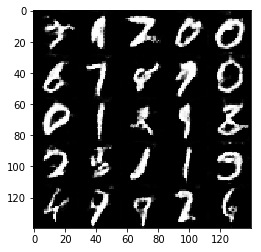

Epoch 2/2... Discriminator Loss: 1.2337... Generator Loss: 1.3035
Epoch 2/2... Discriminator Loss: 1.2691... Generator Loss: 1.2116
Epoch 2/2... Discriminator Loss: 1.9013... Generator Loss: 0.2683
Epoch 2/2... Discriminator Loss: 1.3759... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 1.8443... Generator Loss: 0.3301


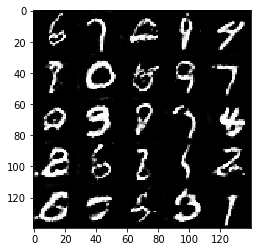

Epoch 2/2... Discriminator Loss: 1.4288... Generator Loss: 0.5688
Epoch 2/2... Discriminator Loss: 1.7213... Generator Loss: 0.3524
Epoch 2/2... Discriminator Loss: 1.2572... Generator Loss: 0.8798
Epoch 2/2... Discriminator Loss: 1.0813... Generator Loss: 1.0399
Epoch 2/2... Discriminator Loss: 1.2180... Generator Loss: 0.9535


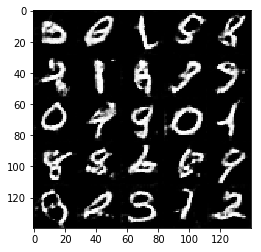

Epoch 2/2... Discriminator Loss: 2.0425... Generator Loss: 2.6684
Epoch 2/2... Discriminator Loss: 1.2650... Generator Loss: 0.8701
Epoch 2/2... Discriminator Loss: 1.0934... Generator Loss: 1.0766
Epoch 2/2... Discriminator Loss: 1.2306... Generator Loss: 0.9171
Epoch 2/2... Discriminator Loss: 1.6211... Generator Loss: 2.1709


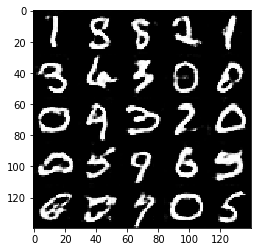

Epoch 2/2... Discriminator Loss: 1.3337... Generator Loss: 1.4260
Epoch 2/2... Discriminator Loss: 1.1034... Generator Loss: 1.3651
Epoch 2/2... Discriminator Loss: 2.2198... Generator Loss: 0.2056
Epoch 2/2... Discriminator Loss: 1.3274... Generator Loss: 0.6516
Epoch 2/2... Discriminator Loss: 1.3811... Generator Loss: 0.5284


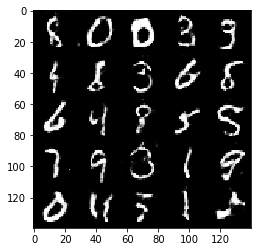

Epoch 2/2... Discriminator Loss: 1.1687... Generator Loss: 0.8186
Epoch 2/2... Discriminator Loss: 1.0856... Generator Loss: 1.0218
Epoch 2/2... Discriminator Loss: 1.4706... Generator Loss: 1.6319
Epoch 2/2... Discriminator Loss: 1.3232... Generator Loss: 0.5871
Epoch 2/2... Discriminator Loss: 2.3091... Generator Loss: 0.2161


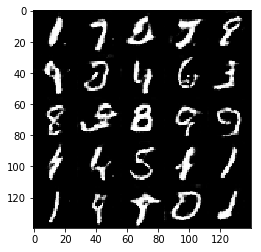

Epoch 2/2... Discriminator Loss: 1.2484... Generator Loss: 0.7386
Epoch 2/2... Discriminator Loss: 2.3155... Generator Loss: 0.2011
Epoch 2/2... Discriminator Loss: 1.0651... Generator Loss: 0.9746
Epoch 2/2... Discriminator Loss: 1.0714... Generator Loss: 1.5287
Epoch 2/2... Discriminator Loss: 1.4862... Generator Loss: 0.4529


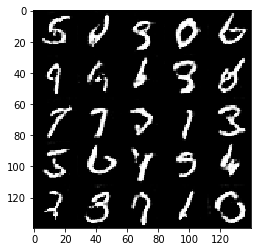

Epoch 2/2... Discriminator Loss: 1.3279... Generator Loss: 0.6411
Epoch 2/2... Discriminator Loss: 1.0713... Generator Loss: 1.1818
Epoch 2/2... Discriminator Loss: 1.1581... Generator Loss: 0.7485
Epoch 2/2... Discriminator Loss: 2.6688... Generator Loss: 0.1496
Epoch 2/2... Discriminator Loss: 1.3427... Generator Loss: 0.8071


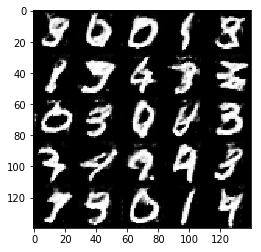

Epoch 2/2... Discriminator Loss: 1.3995... Generator Loss: 0.6224
Epoch 2/2... Discriminator Loss: 1.8976... Generator Loss: 0.2899
Epoch 2/2... Discriminator Loss: 1.2151... Generator Loss: 0.7777


In [57]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 2.6568... Generator Loss: 1.0731
Epoch 1/1... Discriminator Loss: 2.2641... Generator Loss: 0.2628
Epoch 1/1... Discriminator Loss: 1.5633... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.9516... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.7030... Generator Loss: 0.9467


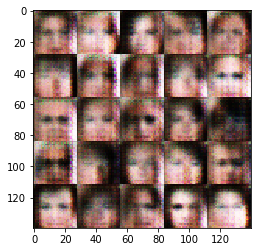

Epoch 1/1... Discriminator Loss: 1.6859... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 2.0301... Generator Loss: 0.4603
Epoch 1/1... Discriminator Loss: 1.8069... Generator Loss: 0.4778
Epoch 1/1... Discriminator Loss: 1.7500... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.9404


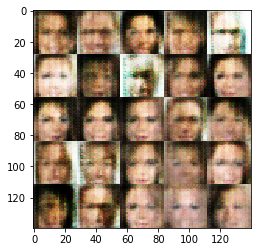

Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.5365... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.6439... Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 0.7108


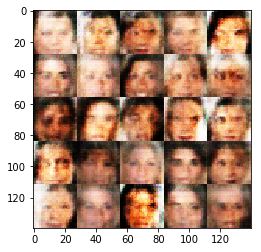

Epoch 1/1... Discriminator Loss: 1.5701... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.7328... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7420


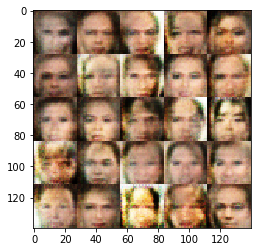

Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.8329... Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.7774


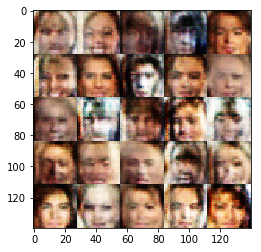

Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.6386... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.5150... Generator Loss: 0.6380


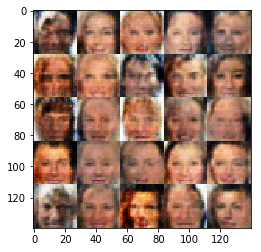

Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 0.7157


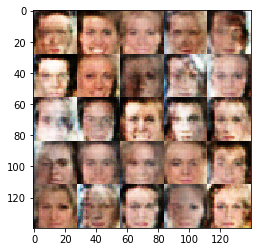

Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 1.6663... Generator Loss: 0.6281


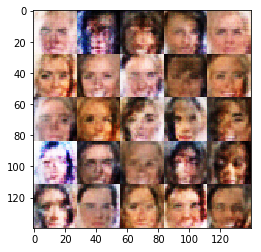

Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.5780... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7997


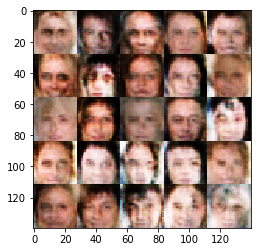

Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 1.2478


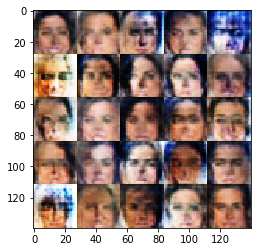

Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7199


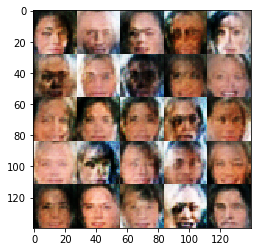

Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.6887... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.8098


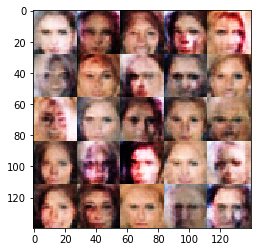

Epoch 1/1... Discriminator Loss: 1.6435... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.9859
Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.8006


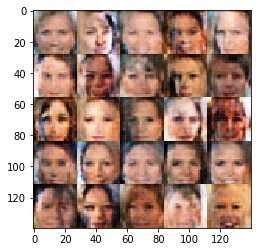

Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.6418... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.8044


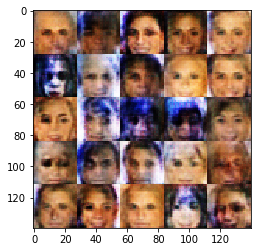

Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7546


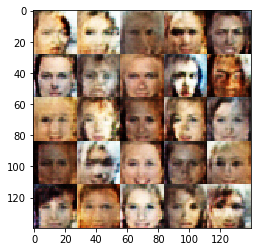

Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.6678... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.6372


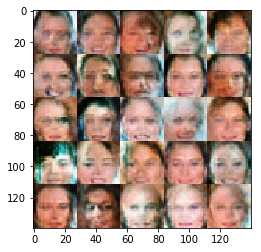

Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.7516


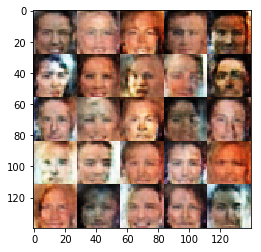

Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.6633... Generator Loss: 0.5358


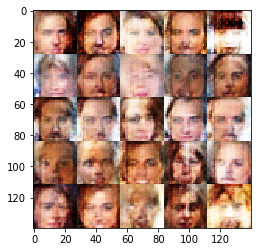

Epoch 1/1... Discriminator Loss: 1.6035... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.7111


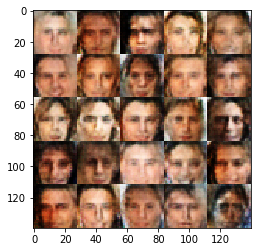

Epoch 1/1... Discriminator Loss: 1.5761... Generator Loss: 1.0672
Epoch 1/1... Discriminator Loss: 1.6373... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.5447... Generator Loss: 0.6932


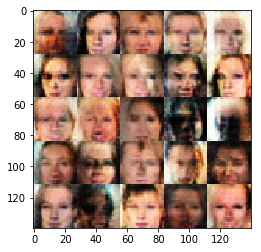

Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.8223


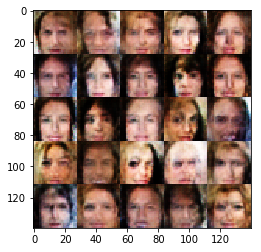

Epoch 1/1... Discriminator Loss: 1.6435... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.6547... Generator Loss: 0.4495
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.8049


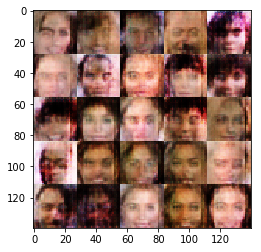

Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.5431... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.8616


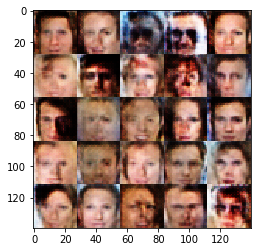

Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.5835... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.8978


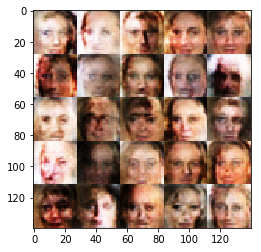

Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7970


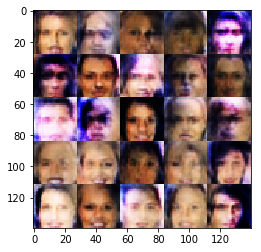

Epoch 1/1... Discriminator Loss: 1.5960... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.5417... Generator Loss: 0.9557


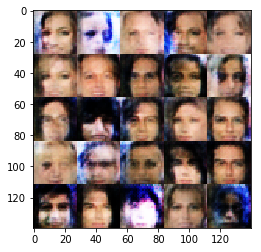

Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.6824


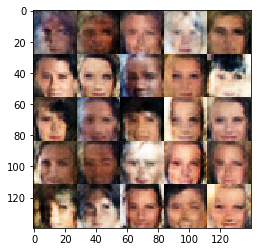

Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.8430


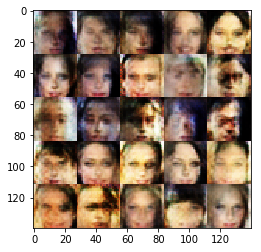

Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 1.0616
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 1.0387


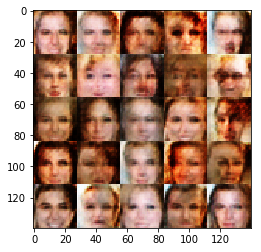

Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.9761
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.7790


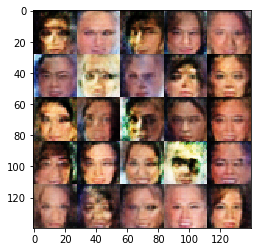

Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.8562


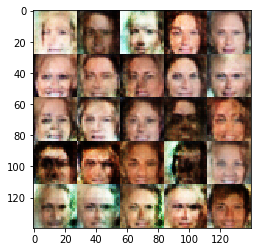

Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 1.0397
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.8802


In [67]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。